In [100]:
#| label: load-pkgs
#| message: false
#| Warning: false

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [101]:
# Loading the dataset
flights_dt = pd.read_csv('data/flights.csv')

flights_dt.head()

,YEAR,MONTH_NUM,MONTH_MON,FLT_DATE,APT_ICAO,APT_NAME,STATE_NAME,FLT_DEP_1,FLT_ARR_1,FLT_TOT_1,FLT_DEP_IFR_2,FLT_ARR_IFR_2,FLT_TOT_IFR_2,Pivot Label
0,2016,1,JAN,2016-01-01T00:00:00Z,EBAW,Antwerp,Belgium,4,3,7,NaN,NaN,NaN,Antwerp (EBAW)
1,2016,1,JAN,2016-01-01T00:00:00Z,EBBR,Brussels,Belgium,174,171,345,174.0,161.0,335.0,Brussels (EBBR)
2,2016,1,JAN,2016-01-01T00:00:00Z,EBCI,Charleroi,Belgium,45,47,92,45.0,45.0,90.0,Charleroi (EBCI)
3,2016,1,JAN,2016-01-01T00:00:00Z,EBLG,Liège,Belgium,6,7,13,NaN,NaN,NaN,Liège (EBLG)
4,2016,1,JAN,2016-01-01T00:00:00Z,EBOS,Ostend-Bruges,Belgium,7,7,14,NaN,NaN,NaN,Ostend-Bruges (EBOS)


In [102]:
# Performing EDA

# Convert FLT_DATE to datetime
flights_dt['FLT_DATE'] = pd.to_datetime(flights_dt['FLT_DATE'], errors='coerce')

# Add a new column 
flights_dt['YEAR_MONTH'] = flights_dt['FLT_DATE'].dt.tz_localize(None).dt.to_period('M')

# Handle missing values
flight_columns = ['FLT_DEP_1', 'FLT_ARR_1', 'FLT_TOT_1', 'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2']
flights_dt[flight_columns] = flights_dt[flight_columns].fillna(0)

flights_dt.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   YEAR           5 non-null      int64              
 1   MONTH_NUM      5 non-null      int64              
 2   MONTH_MON      5 non-null      object             
 3   FLT_DATE       5 non-null      datetime64[ns, UTC]
 4   APT_ICAO       5 non-null      object             
 5   APT_NAME       5 non-null      object             
 6   STATE_NAME     5 non-null      object             
 7   FLT_DEP_1      5 non-null      int64              
 8   FLT_ARR_1      5 non-null      int64              
 9   FLT_TOT_1      5 non-null      int64              
 10  FLT_DEP_IFR_2  5 non-null      float64            
 11  FLT_ARR_IFR_2  5 non-null      float64            
 12  FLT_TOT_IFR_2  5 non-null      float64            
 13  Pivot Label    5 non-null      object             
 14

A. How is the total number monthly flight departures ad arrivals at Brussels Airport comparatively to other major airports in Belgium ?

In [103]:
# Aggregating data
monthly_data = flights_dt.groupby(['YEAR_MONTH', 'APT_NAME']).agg(total_departures=('FLT_DEP_1', 'sum')
                                                                 ,total_arrivals=('FLT_ARR_1', 'sum')
                                                                  ,total_flights=('FLT_TOT_1', 'sum')).reset_index()

# Filtering data
brussels_data = monthly_data[monthly_data['APT_NAME'] == 'Brussels']
other_airports_data = monthly_data[monthly_data['APT_NAME'] != 'Brussels']

# Summarizing data
summary = monthly_data.groupby(['YEAR_MONTH']).agg(
    brussels_total_flights=('total_flights', lambda x: x[monthly_data['APT_NAME'] == 'Brussels'].sum()),
    other_total_flights=('total_flights', lambda x: x[monthly_data['APT_NAME'] != 'Brussels'].sum())
).reset_index()

summary.head()

,YEAR_MONTH,brussels_total_flights,other_total_flights
0,2016-01,16639,7286
1,2016-02,16973,7577
2,2016-03,13371,10109
3,2016-04,11941,10880
4,2016-05,20210,9193


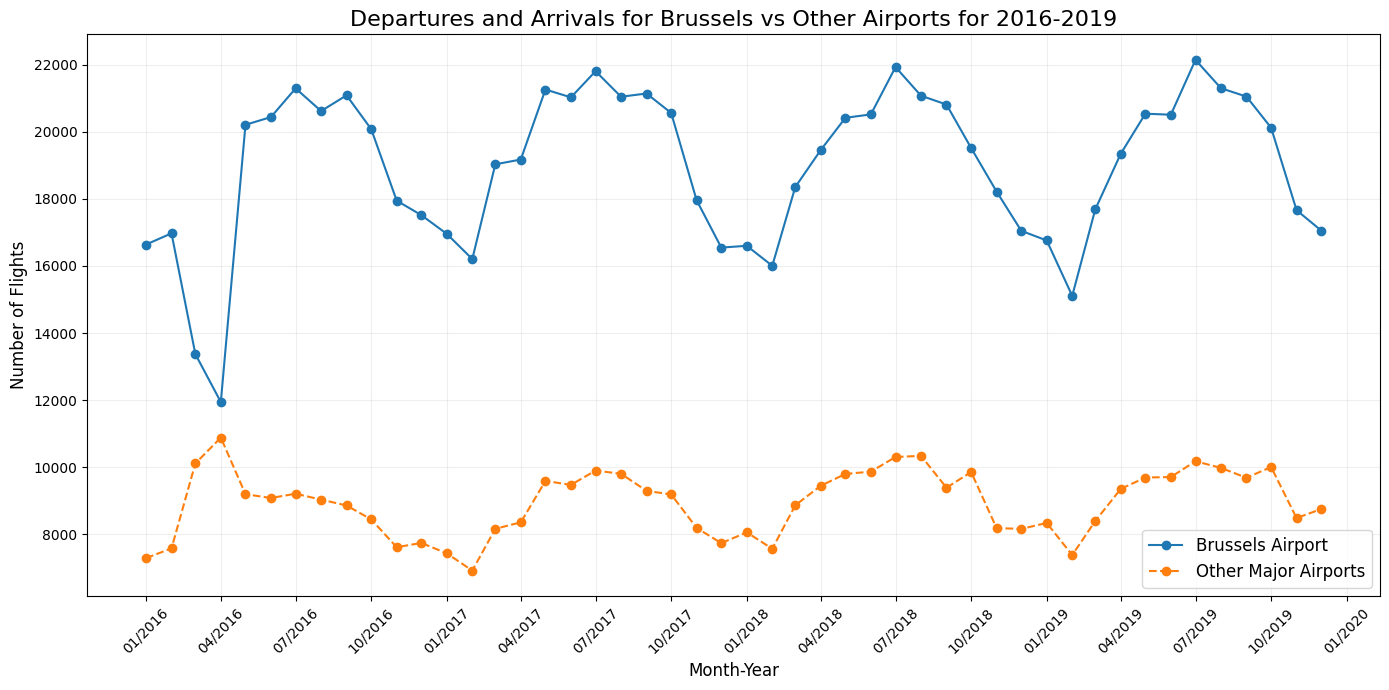

In [109]:
# Summarizing data
summary['YEAR_MONTH'] = pd.to_datetime(summary['YEAR_MONTH'].astype(str))

# Creating the plot
plt.figure(figsize=(14, 7))
plt.plot(summary['YEAR_MONTH'], summary['brussels_total_flights'], label='Brussels Airport', linewidth=1.5, marker='o')
plt.plot(summary['YEAR_MONTH'], summary['other_total_flights'], label='Other Major Airports', linewidth=1.5, linestyle='--', marker='o')

# Formatting the plot
plt.title('Departures and Arrivals for Brussels vs Other Airports for 2016-2019', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)

# Formating x-axis label (m/y)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

B. what are the seasonal trends over the year?

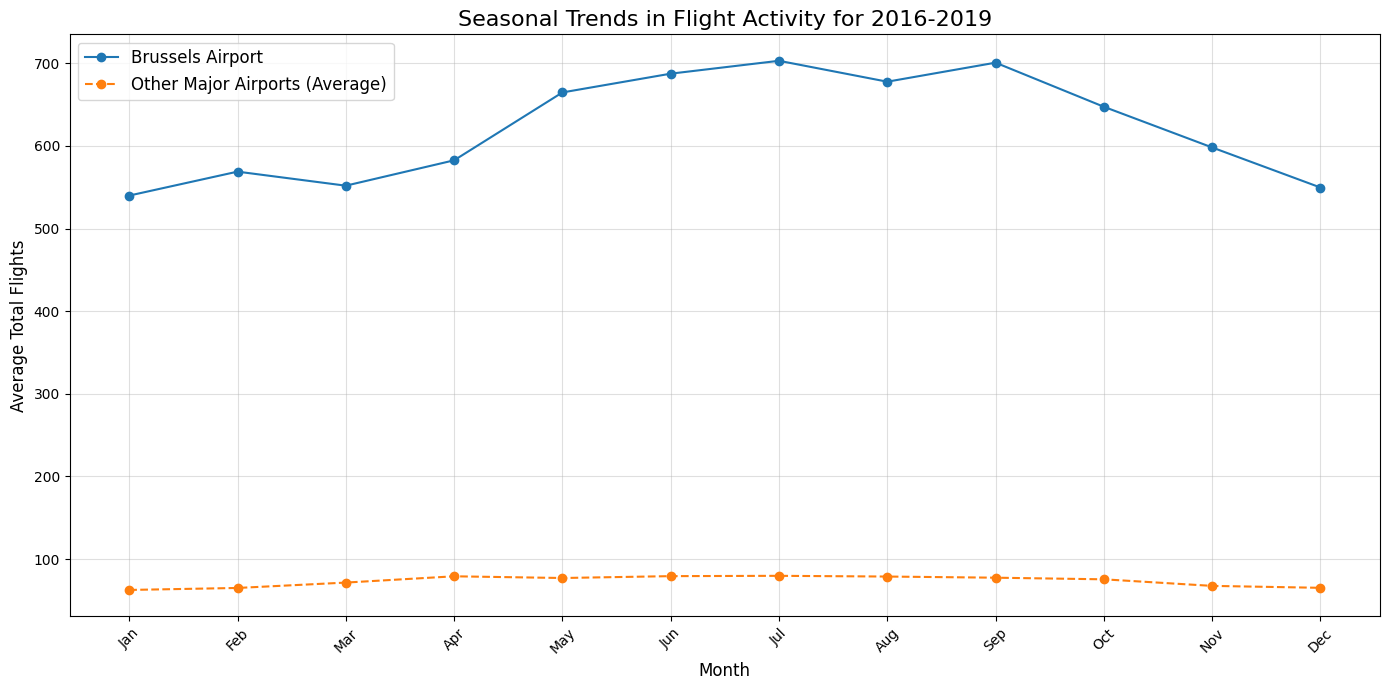

In [105]:
# Aggregating data for seasonal trends
seasonal_data = flights_dt.groupby(['MONTH_NUM', 'APT_NAME']).agg(
    avg_departures=('FLT_DEP_1', 'mean'),
    avg_arrivals=('FLT_ARR_1', 'mean'),
    avg_total_flights=('FLT_TOT_1', 'mean')
).reset_index()

brussels_seasonal = seasonal_data[seasonal_data['APT_NAME'] == 'Brussels']
other_airports_seasonal = seasonal_data[seasonal_data['APT_NAME'] != 'Brussels'].groupby('MONTH_NUM').agg(
    avg_departures=('avg_departures', 'mean'),
    avg_arrivals=('avg_arrivals', 'mean'),
    avg_total_flights=('avg_total_flights', 'mean')
).reset_index()

# Creating Brussels seasonal trends
plt.figure(figsize=(14, 7))
plt.plot(brussels_seasonal['MONTH_NUM'], brussels_seasonal['avg_total_flights'], 
         label='Brussels Airport', linewidth=1.5, marker='o')
plt.plot(other_airports_seasonal['MONTH_NUM'], other_airports_seasonal['avg_total_flights'], 
         label='Other Major Airports (Average)', linewidth=1.5, marker='o', linestyle='--')
plt.title('Seasonal Trends in Flight Activity for 2016-2019', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Total Flights', fontsize=12)
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation=45, fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()

plt.show()

C. Hypothesis Testing

In [106]:
from scipy.stats import chi2_contingency, kruskal

# contingency table
contingency_table = flights_dt.pivot_table(
    index='MONTH_NUM', columns='APT_NAME', values='FLT_TOT_1', aggfunc='sum', fill_value=0
)

contingency_table_shape = contingency_table.shape

# If there are sufficient categories for comparison perform  Chi-Square Test
if contingency_table_shape[0] > 1 and contingency_table_shape[1] > 1:
    chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)
    test_used = "Chi-Square Test"
else:
    # H-Test
    grouped_data = [flights_dt[flights_dt['APT_NAME'] == airport]['FLT_TOT_1'] for airport in flights_dt['APT_NAME'].unique()]
    h_stat, p_value_h = kruskal(*grouped_data)
    test_used = "Kruskal-Wallis H-Test"

test_used


'Chi-Square Test'

In [107]:
# Test Results
chi2_test_results = {
    'Chi-Square Statistic': chi2_stat,
    'p-value': p_value_chi2,
    'Degrees of Freedom': dof
}
chi2_test_results

{'Chi-Square Statistic': np.float64(2323.9454386944262),
 'p-value': np.float64(0.0),
 'Degrees of Freedom': 44}

D. Statistical Analysis

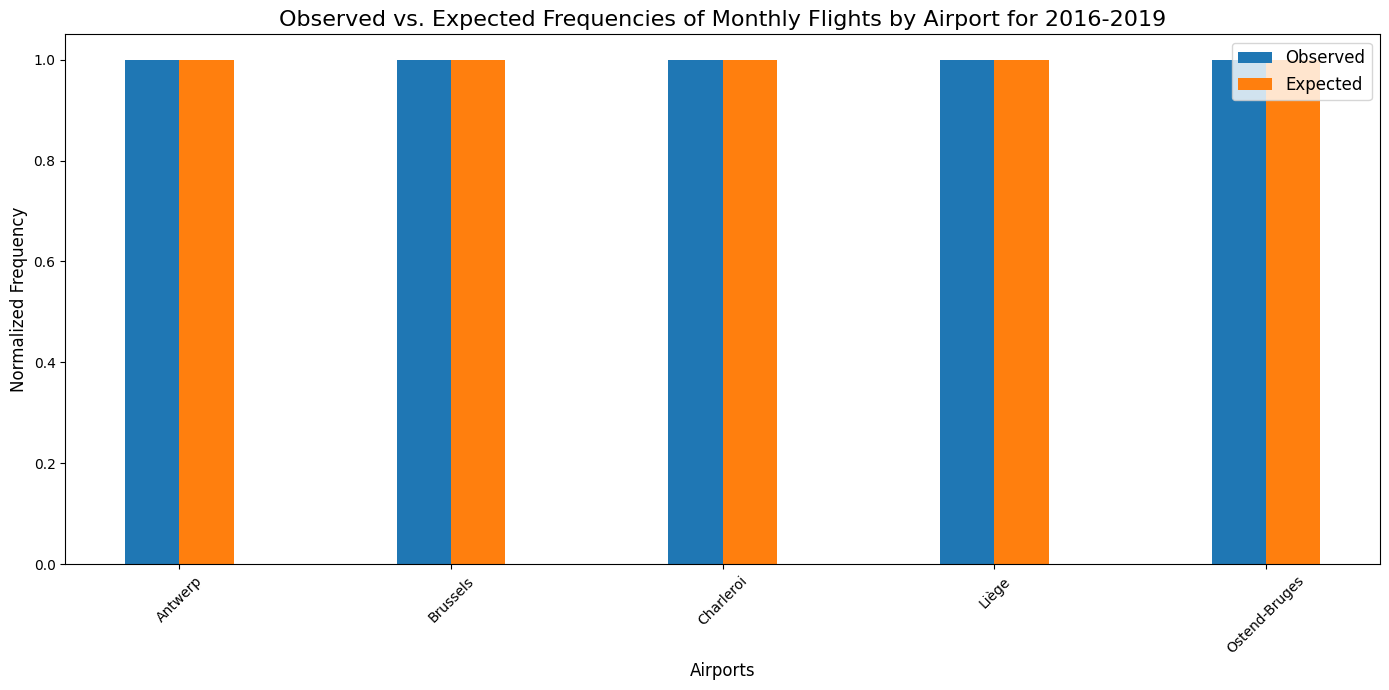

In [108]:
# frequencies from Chi-Square Test
observed = contingency_table.values
expected = expected

# frequencies for comparison
observed_normalized = observed / np.sum(observed, axis=0)
expected_normalized = expected / np.sum(expected, axis=0)
airports = contingency_table.columns
plt.figure(figsize=(14, 7))
x = np.arange(len(airports))

# Creating bar plot
bar_width = 0.2
plt.bar(x - bar_width / 2, observed_normalized.sum(axis=0), bar_width, label='Observed')
plt.bar(x + bar_width / 2, expected_normalized.sum(axis=0), bar_width, label='Expected')
plt.title('Observed vs. Expected Frequencies of Monthly Flights by Airport for 2016-2019', fontsize=16)
plt.xlabel('Airports', fontsize=12)
plt.ylabel('Normalized Frequency', fontsize=12)
plt.xticks(x, airports, rotation=45, fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()